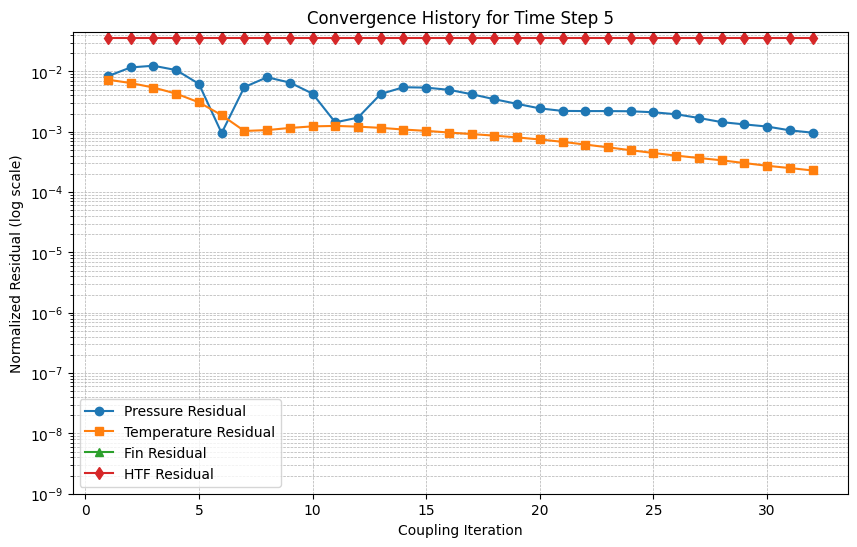

Time step 5 complete. HTF Outlet Temperature: 350.77 K
Generating cross-section plots for Time Step 4...


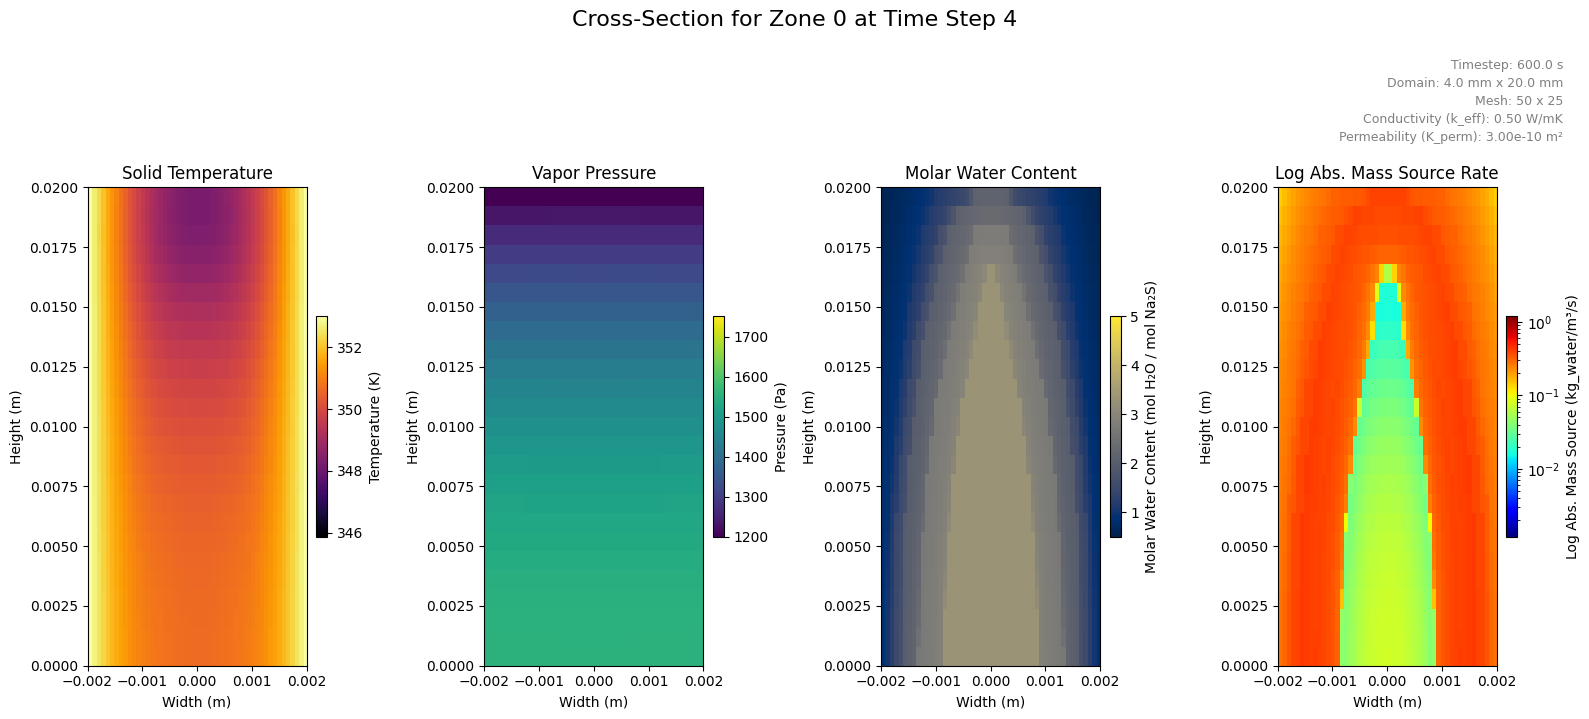


--- Time step 6/100, Time: 3000.00s ---
Starting coupling loop...
  [Coupling Iter 1] P_residual: 4.58e-03, T_residual: 6.50e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.100
  [Coupling Iter 2] P_residual: 2.44e-03, T_residual: 5.42e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.120
  [Coupling Iter 3] P_residual: 3.08e-03, T_residual: 4.20e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.144
  [Coupling Iter 4] P_residual: 8.42e-03, T_residual: 2.99e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.173
  [Coupling Iter 5] P_residual: 1.26e-02, T_residual: 1.92e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.207
  [Coupling Iter 6] P_residual: 1.39e-02, T_residual: 1.29e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.249
  [Coupling Iter 7] P_residual: 9.20e-03, T_residual: 1.17e-03, T_fin_residual: 0.00e+00, T_HTF_residual: 3.36e-02, new omega: 0.250
  

In [ ]:
import numpy as np
import time
import multiprocessing # <-- Import multiprocessing
from simulation_parameters import *
from utils import *
from physics_solvers import *
from outdated_functions import *
from plotting_utils import log_and_plot_timestep, plot_final_heatmaps
from IPython.display import clear_output # Import the clear_output function

def initialize_state():
    """Initializes all state variables for the simulation."""
    print("Initializing reactor...")
    
    # State variables (lists of arrays, one for each zone)
    T_zones = [np.full((NZ, NX), float(T_INITIAL)) for _ in range(NUM_ZONES)]
    P_zones = [np.full((NZ, NX), float(P_INITIAL)) for _ in range(NUM_ZONES)] 
    alphas_zones = [np.tile(ALPHA_INITIAL, (NZ, NX, 1)) for _ in range(NUM_ZONES)]
    avg_mass_source_zones = [np.zeros((NZ, NX)) for _ in range(NUM_ZONES)]
    
    # HTF and Fin temperatures (1D arrays)
    T_htf_zones = np.full(NUM_ZONES, float(T_INITIAL))
    T_fin_zones = np.full(NUM_ZONES, float(T_INITIAL))
    
    # History for plots
    history = {
        'time': [], 'T_avg': [], 'P_avg': [], 'alpha_avg': [],
        'T_fin_avg': [], 'T_htf_out': [], 'mass_vaporized': []
    }
    
    return T_zones, P_zones, alphas_zones, avg_mass_source_zones, T_htf_zones, T_fin_zones, history


def solve_physics_worker(args):
    """
    Solves P and T equations for a single zone.
    This function is designed to be called by multiprocessing.Pool.
    """
    # Unpack arguments
    (P_guess, avg_mass_source, T_guess, alphas_old, P_inf, 
     T_old, avg_heat_source, T_fin_guess, dt) = args
    
    # Solve Pressure
    P_new = solve_pressure(
        P_guess, avg_mass_source, T_guess, alphas_old, P_inf, use_warm_start=True
    )
    
    # Solve Temperature
    T_new_array, Q_from_solid_i = solve_heat_equation(
        T_old, avg_heat_source, alphas_old, T_fin_guess, dt
    )
    
    return P_new, T_new_array, Q_from_solid_i


def solve_coupling_loop(n, dt, T_zones, P_zones, alphas_zones, avg_mass_source_zones, T_fin_zones, T_htf_zones):
    """Solves the main physics coupling loop for a single time step."""
    
    # Store state at the beginning of the time step
    alphas_old_zones = [a.copy() for a in alphas_zones]
    mass_source_guess_zones = [m.copy() for m in avg_mass_source_zones]
    avg_heat_source_zones_guess = [np.zeros((NZ, NX)) for _ in range(NUM_ZONES)] # Added for heat source relaxation
    
    # Guesses for the coupling loop
    T_guess_zones = [T.copy() for T in T_zones]
    P_guess_zones = [P.copy() for P in P_zones]
    T_fin_guess_zones = np.copy(T_fin_zones)
    T_htf_guess_zones = np.copy(T_htf_zones)
    
    current_omega = OMEGA_MASS_SOURCE_INITIAL
    last_P_residual = np.inf
    last_T_residual = np.inf # Added for T residual tracking
    
    # History for convergence plot
    residual_histories = {'P': [], 'T': [], 'Fin': [], 'HTF': []}
    
    print("Starting coupling loop...")
    for coupling_iter in range(MAX_ITER_COUPLING):
        
        # --- 3a/3b. Predict Sources and Apply Relaxation ---
        try:
            alphas_final_zones, avg_mass_source_zones, avg_heat_source_zones_guess = update_sources_and_relax(
                alphas_old_zones, T_guess_zones, P_guess_zones, dt,
                mass_source_guess_zones, avg_heat_source_zones_guess, current_omega
            )
            # Update the mass source guess for the *next* iteration
            mass_source_guess_zones = avg_mass_source_zones
            
        except RuntimeError as e:
            # Catch the NaN/Inf error raised from the utils function
            print(f"  [Coupling Iter {coupling_iter+1}] CRITICAL ERROR: {e}")
            raise e # Re-raise to stop simulation

        # --- 3c. Solve Spatial Physics (Parallel) ---
        P_new_guess_zones = []
        T_new_guess_zones = []
        Q_from_solid_zones_new = []
        
        # 1. Build argument list for parallel workers
        physics_args_list = []
        for i in range(NUM_ZONES):
            physics_args_list.append((
                P_guess_zones[i], avg_mass_source_zones[i], T_guess_zones[i], alphas_old_zones[i], P_INF, 
                T_zones[i], avg_heat_source_zones_guess[i], T_fin_guess_zones[i], dt
            ))

        # 2. Run P and T solvers in parallel
        with multiprocessing.Pool() as pool:
            physics_results = pool.map(solve_physics_worker, physics_args_list)

        # 3. Reconstruct results
        for P_new, T_new_array, Q_from_solid_i in physics_results:
            P_new_guess_zones.append(P_new)
            T_new_guess_zones.append(T_new_array)
            Q_from_solid_zones_new.append(Q_from_solid_i)

        # # --- 3d. Update HTF and Fin Temps (Sequential) ---
        # T_fin_new_zones, T_htf_new_zones = solve_fin_htf_network(
        #     Q_from_solid_zones_new,  # Pass Q (Watts)
        #     T_fin_guess_zones,       # Pass old guess for failure case
        #     T_htf_guess_zones,       # Pass old guess for failure case
        #     T_HTF_IN,
        #     HTF_MASS_FLOW,
        #     CP_HTF,
        #     NUM_ZONES
        # )
        
        # --- 3d. Update HTF and Fin Temps (Sequential) ---
        T_fin_new_zones, T_htf_new_zones = solve_fin_htf_network_empty(
            T_new_guess_zones,  # From parallel step 3c
            T_fin_guess_zones,  # Current guess
            T_HTF_IN,
            HTF_MASS_FLOW,
            CP_HTF,
            NUM_ZONES
        )
        
        # --- 3f. Check Convergence & Adapt ---
        T_converged = check_convergence(T_new_guess_zones, T_guess_zones, TOLERANCE_COUPLING)
        P_converged = check_convergence(P_new_guess_zones, P_guess_zones, TOLERANCE_COUPLING)
        Fin_converged = check_convergence(T_fin_new_zones, T_fin_guess_zones, TOLERANCE_COUPLING)
        HTF_converged = check_convergence(T_htf_new_zones, T_htf_guess_zones, TOLERANCE_COUPLING)
        
        current_T_residual = calculate_residual(T_new_guess_zones, T_guess_zones)
        current_P_residual = calculate_residual(P_new_guess_zones, P_guess_zones)
        current_Fin_residual = calculate_residual(T_fin_new_zones, T_fin_guess_zones)
        current_HTF_residual = calculate_residual(T_htf_new_zones, T_htf_guess_zones)
        
        # Store residuals for plotting
        residual_histories['T'].append(current_T_residual)
        residual_histories['P'].append(current_P_residual)
        residual_histories['Fin'].append(current_Fin_residual)
        residual_histories['HTF'].append(current_HTF_residual)
        
        if np.isnan(current_P_residual) or np.isnan(current_T_residual):
            print(f"  [Coupling Iter {coupling_iter+1}] CRITICAL: Residual is NaN.")
            print(f"  RECOMMENDATION: Reduce DT (currently {DT}) in simulation_parameters.py.")
            raise RuntimeError(f"Solver failed (NaN residual). Reduce DT from {DT}.")
        
        if coupling_iter > 0:
            if current_P_residual < last_P_residual or current_T_residual < last_T_residual:
                current_omega = min(current_omega * ADAPTIVE_OMEGA_INCREASE, OMEGA_MASS_SOURCE_MAX)
            else:
                current_omega = max(current_omega * ADAPTIVE_OMEGA_DECREASE, OMEGA_MASS_SOURCE_MIN)
            
            last_P_residual = current_P_residual
            last_T_residual = current_T_residual 

        if (coupling_iter + 1) % 1 == 0 or coupling_iter == MAX_ITER_COUPLING - 1:
             print(f"  [Coupling Iter {coupling_iter+1}] P_residual: {current_P_residual:.2e}, T_residual: {current_T_residual:.2e}, T_fin_residual: {current_Fin_residual:.2e}, T_HTF_residual: {current_HTF_residual:.2e}, new omega: {current_omega:.3f}")

        
        # --- 3g. Apply State Relaxation ---
        
        halving_factor = 0.5 ** (coupling_iter // 100)
        current_omega_T_ceiling = OMEGA_STATE_RELAXATION_T * halving_factor
        current_omega_P_ceiling = OMEGA_STATE_RELAXATION_P * halving_factor

        max_delta_T = 0.0
        max_delta_P = 0.0
        for i in range(NUM_ZONES):
            max_delta_T = max(max_delta_T, np.max(np.abs(T_new_guess_zones[i] - T_guess_zones[i])))
            max_delta_P = max(max_delta_P, np.max(np.abs(P_new_guess_zones[i] - P_guess_zones[i])))

        MAX_CHANGE_T = 1.0 
        MAX_CHANGE_P = 500.0 
        
        omega_T = min(current_omega_T_ceiling, MAX_CHANGE_T / (max_delta_T + 1e-10))
        omega_P = min(current_omega_P_ceiling, MAX_CHANGE_P / (max_delta_P + 1e-10))

        for i in range(NUM_ZONES):
            T_guess_zones[i] = (1.0 - omega_T) * T_guess_zones[i] + omega_T * T_new_guess_zones[i]
            P_guess_zones[i] = (1.0 - omega_P) * P_guess_zones[i] + omega_P * P_new_guess_zones[i]
        
        T_fin_guess_zones = (1.0 - omega_T) * T_fin_guess_zones + omega_T * T_fin_new_zones
        T_htf_zones = (1.0 - omega_T) * T_htf_guess_zones + omega_T * T_htf_new_zones # Use T_htf_guess_zones
        
        HTF_converged = True
        Fin_converged = True
        
        if T_converged and P_converged and Fin_converged and HTF_converged and coupling_iter >= 4:
            print(f"Coupling loop converged in {coupling_iter + 1} iterations.")
            break 
            
    return T_guess_zones, P_guess_zones, T_fin_guess_zones, alphas_final_zones, avg_mass_source_zones, T_htf_zones, residual_histories


def run_simulation():
    # --- 1. Initialization ---
    T_zones, P_zones, alphas_zones, avg_mass_source_zones, \
    T_htf_zones, T_fin_zones, history = initialize_state()
    
    # --- 2. Main Time Loop ---
    for n in range(NUM_TIMESTEPS):
        t_current = n * DT
        print(f"\n--- Time step {n+1}/{NUM_TIMESTEPS}, Time: {t_current:.2f}s ---")

        # --- 3. Main Coupling Loop (Solves the time step) ---
        T_guess, P_guess, T_fin_guess, alphas_final, \
        avg_mass_source_final, T_htf_final, residual_histories = solve_coupling_loop(
            n, DT, T_zones, P_zones, alphas_zones, 
            avg_mass_source_zones, T_fin_zones, T_htf_zones
        )
        
        # --- 4. Finalize Time Step ---
        T_zones = T_guess
        P_zones = P_guess
        T_fin_zones = T_fin_guess
        alphas_zones = alphas_final
        avg_mass_source_zones = avg_mass_source_final # Store converged source
        T_htf_zones = T_htf_final # Store converged HTF temps
        
        # --- 5. Output and Store Results for the Time Step ---
        clear_output(wait=True) # Clear console output for ipynb
        log_and_plot_timestep(
            n, T_zones, P_zones, alphas_zones, 
            avg_mass_source_zones, T_htf_zones, T_fin_zones, history,
            DT, NX, NZ, residual_histories # Pass residuals
        )
    
    # --- 6. Plotting ---
    plot_final_heatmaps(history)

    print("\nHistory (last step):")
    for key, value in history.items():
        if value:
            # Check if value is a list of lists/arrays or just a list of floats
            try:
                # Try to access the last element of the list
                last_item = value[-1]
                # If that last element is *also* a list/array (like avg_temp), get its mean
                if hasattr(last_item, 'mean') and not isinstance(last_item, float):
                    print(f"  {key}: (avg) {np.mean(last_item):.4f}")
                else:
                    # It's a simple list (like 'time' or 'T_htf_out')
                    print(f"  {key}: {last_item:.4f}")
            except (IndexError, TypeError):
                print(f"  {key}: (could not display)")
    
    return history


if __name__ == "__main__":
    # This check is important for multiprocessing to work correctly
    run_simulation()

